In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import datetime
import holidays

import seaborn as sns

In [109]:
#read data
df_trans = pd.read_excel('./demand-forecasting-kernels-only/data_friday_ai.xlsx',sheet_name=5, engine='openpyxl')
df_trans=df_trans.drop(['customer_id','employee_id','invoice_no.','trans_price'],axis=1)

In [110]:
def sort_data_weekly(df):
    
    sort_df = df.sort_values('time_stamp').groupby(['item_id', 'store_id', 'time_stamp'], as_index=False)
    sort_df = sort_df.agg({'quantity':['sum']})
    sort_df.columns = ['item', 'store', 'date', 'sales']
    
    sort_df=sort_df.set_index('date')
    sort_df['week']=sort_df.index.isocalendar().week
    
    return sort_df


def select_item_shop(df,item_id,shop_id):
    df=df[(df['store']==shop_id)&(df['item']==item_id)]
    df_r=df.drop(['item','store'],axis=1)
    return df_r


def additional_info(df):
    
    weekend=[]
    holiday=[]
    sg_holidays = holidays.SG()
    for i, row in df.iterrows():
        weekno=i.weekday()

        if weekno < 5:
            weekend.append(0)
        else:  # 5 Sat, 6 Sun
            weekend.append(1)

        if i in sg_holidays:
            holiday.append(1)
        else:
            holiday.append(0)

    df['is_weekend']=weekend
    df['is_holiday']=holiday
    
    return df

def sum_by_week(df):
    
    df=df.groupby(['week']).sum()
    return df

In [111]:
df=sort_data_weekly(df_trans)
df=select_item_shop(df,2,1)
df=additional_info(df)
df=sum_by_week(df)

In [116]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

43 3


In [24]:
from sklearn.preprocessing import RobustScaler

f_columns = ['is_weekend', 'is_holiday']


f_transformer = RobustScaler()
sales_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
sales_transformer = sales_transformer.fit(train[['sales']])

train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train['sales'] = sales_transformer.transform(train[['sales']])

test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test['sales'] = sales_transformer.transform(test[['sales']])

/Users/mingze/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/mingze/opt/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/mingze/opt/anaconda3/envs/tf/lib/python3.7/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [25]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [26]:
time_steps = 1

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train, train.sales, time_steps)
X_test, y_test = create_dataset(test, test.sales, time_steps)

print(X_train.shape, y_train.shape)

(42, 1, 3) (42,)


In [33]:
model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=32, 
      input_shape=(X_train.shape[1], X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
history = model.fit(
    X_train, y_train, 
    epochs=10, 
    batch_size=32, 
    validation_split=0.1,
    verbose=2,
    shuffle=False
)

Train on 37 samples, validate on 5 samples
Epoch 1/10
37/37 - 3s - loss: 0.1999 - val_loss: 0.8650
Epoch 2/10
37/37 - 0s - loss: 0.1980 - val_loss: 0.8660
Epoch 3/10
37/37 - 0s - loss: 0.2000 - val_loss: 0.8663
Epoch 4/10
37/37 - 0s - loss: 0.1946 - val_loss: 0.8665
Epoch 5/10
37/37 - 0s - loss: 0.1959 - val_loss: 0.8664
Epoch 6/10
37/37 - 0s - loss: 0.2024 - val_loss: 0.8662
Epoch 7/10
37/37 - 0s - loss: 0.2005 - val_loss: 0.8660
Epoch 8/10
37/37 - 0s - loss: 0.1990 - val_loss: 0.8659
Epoch 9/10
37/37 - 0s - loss: 0.1973 - val_loss: 0.8659
Epoch 10/10
37/37 - 0s - loss: 0.1962 - val_loss: 0.8659


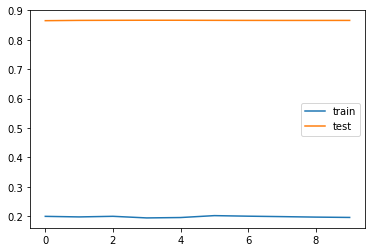

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [36]:
y_pred = model.predict(X_test)

In [37]:
y_train_inv = sales_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = sales_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = sales_transformer.inverse_transform(y_pred)

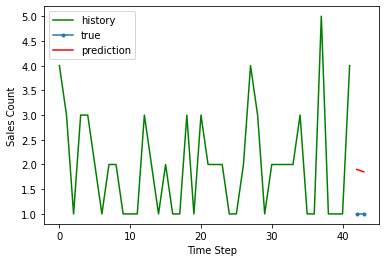

In [38]:
plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
plt.ylabel('Sales Count')
plt.xlabel('Time Step')
plt.legend()
plt.show();